In [ ]:
! pip3 install xgboost catboost lightgbm optuna

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import optuna

In [3]:
df = pd.read_csv('train.csv')

# Data Inspection

In [3]:
df.head()

,SEQN,self_eval,teacher_eval,extracurricular,district,SRP_1,SRP_2,SRP_3,SRP_4,SRP_5,...,SRP_42,SRP_43,SRP_44,SRP_45,SRP_46,SRP_47,SRP_48,SRP_49,SRP_50,y
0,969167,4,5,9,3,-0.181,-0.379,-0.164,0.080,0.378,...,-1.156,-0.730,-0.508,-0.497,0.224,0.412,-0.517,0.099,0.114,-1.315
1,188942,4,3,5,4,-0.126,1.603,1.021,0.489,-1.404,...,-0.318,1.240,-1.993,2.021,-1.078,-0.277,0.802,0.253,-0.720,1.997
2,134058,1,2,8,5,0.724,-0.702,2.249,0.910,0.330,...,0.449,1.980,-0.401,-0.544,-0.944,1.592,0.875,-0.734,-2.336,3.709
3,124022,3,3,10,6,0.706,-0.302,1.023,-0.895,0.625,...,2.025,-2.289,-0.407,0.025,-0.515,0.408,1.380,-1.075,-2.451,1.155
4,685285,5,5,1,5,-0.350,-1.001,0.931,0.192,0.491,...,-0.118,-0.288,0.457,-0.566,0.822,-0.317,0.661,2.096,0.004,-1.960


In [4]:
df.dtypes

SEQN                 int64
self_eval            int64
teacher_eval         int64
extracurricular      int64
district             int64
SRP_1              float64
SRP_2              float64
SRP_3              float64
SRP_4              float64
SRP_5              float64
SRP_6              float64
SRP_7              float64
SRP_8              float64
SRP_9              float64
SRP_10             float64
SRP_11             float64
SRP_12             float64
SRP_13             float64
SRP_14             float64
SRP_15             float64
SRP_16             float64
SRP_17             float64
SRP_18             float64
SRP_19             float64
SRP_20             float64
SRP_21             float64
SRP_22             float64
SRP_23             float64
SRP_24             float64
SRP_25             float64
SRP_26             float64
SRP_27             float64
SRP_28             float64
SRP_29             float64
SRP_30             float64
SRP_31             float64
SRP_32             float64
S

In [5]:
df.isna().sum()

SEQN               0
self_eval          0
teacher_eval       0
extracurricular    0
district           0
SRP_1              0
SRP_2              0
SRP_3              0
SRP_4              0
SRP_5              0
SRP_6              0
SRP_7              0
SRP_8              0
SRP_9              0
SRP_10             0
SRP_11             0
SRP_12             0
SRP_13             0
SRP_14             0
SRP_15             0
SRP_16             0
SRP_17             0
SRP_18             0
SRP_19             0
SRP_20             0
SRP_21             0
SRP_22             0
SRP_23             0
SRP_24             0
SRP_25             0
SRP_26             0
SRP_27             0
SRP_28             0
SRP_29             0
SRP_30             0
SRP_31             0
SRP_32             0
SRP_33             0
SRP_34             0
SRP_35             0
SRP_36             0
SRP_37             0
SRP_38             0
SRP_39             0
SRP_40             0
SRP_41             0
SRP_42             0
SRP_43       

In [6]:
df.self_eval.value_counts()

self_eval
4    1635
1    1618
5    1599
3    1574
2    1574
Name: count, dtype: int64

In [7]:
df.teacher_eval.value_counts()

teacher_eval
1    2448
2    1558
3    1536
4    1346
5    1112
Name: count, dtype: int64

In [8]:
df.extracurricular.value_counts()

extracurricular
2     838
6     837
5     832
9     812
8     797
10    795
3     789
4     775
7     769
1     756
Name: count, dtype: int64

In [9]:
df.district.value_counts()

district
2    1170
3    1158
5    1148
1    1137
7    1136
4    1128
6    1123
Name: count, dtype: int64

In [10]:
duplicated_rows = df.duplicated()
if duplicated_rows.any():
    print("There are duplicated rows in df.")
else:
    print("There are no duplicated rows in df.")


There are no duplicated rows in df.


# Data Prepocessing

In [6]:
correlation = df.drop(['SEQN', 'district'], axis=1).corr()
correlation_y = correlation['y'].abs().sort_values(ascending=False)
correlation_y


y                  1.000000
extracurricular    0.149755
SRP_20             0.115713
SRP_9              0.113429
SRP_47             0.110315
SRP_40             0.108693
SRP_15             0.107612
SRP_46             0.105138
SRP_12             0.104504
SRP_19             0.104434
SRP_1              0.103478
SRP_27             0.102983
SRP_3              0.102349
SRP_13             0.101130
SRP_7              0.100855
SRP_28             0.100677
SRP_6              0.099966
SRP_37             0.098517
SRP_39             0.097857
SRP_41             0.095952
SRP_8              0.094737
SRP_35             0.094721
SRP_24             0.094578
SRP_10             0.094183
SRP_14             0.093952
SRP_17             0.093931
SRP_48             0.093091
SRP_4              0.092594
SRP_32             0.092520
SRP_38             0.092379
SRP_22             0.090827
SRP_5              0.089317
SRP_23             0.088495
SRP_26             0.087327
SRP_30             0.086518
SRP_21             0

In [28]:
numerical_features = ['self_eval', 'teacher_eval', 'extracurricular', 'SRP_1', 'SRP_2', 'SRP_3', 'SRP_4', 'SRP_5', 'SRP_6', 'SRP_7', 'SRP_8', 'SRP_9', 'SRP_10', 'SRP_11', 'SRP_12', 'SRP_13', 'SRP_14', 'SRP_15', 'SRP_16', 'SRP_17', 'SRP_18', 'SRP_19', 'SRP_20', 'SRP_21', 'SRP_22', 'SRP_23', 'SRP_24', 'SRP_25', 'SRP_26', 'SRP_27', 'SRP_28', 'SRP_29', 'SRP_30', 'SRP_31', 'SRP_32', 'SRP_33', 'SRP_34', 'SRP_35', 'SRP_36', 'SRP_37', 'SRP_38', 'SRP_39', 'SRP_40', 'SRP_41', 'SRP_42', 'SRP_43', 'SRP_44', 'SRP_45', 'SRP_46', 'SRP_47', 'SRP_48', 'SRP_49', 'SRP_50']
categorical_features = ['district']
columns_to_drop = ['SEQN']

preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  ## only scale the numerical features
        ('cat', OneHotEncoder(), categorical_features),  ## one-hot encode the categorical features
        ('drop', 'drop', columns_to_drop)
    ], remainder='passthrough'  ## passthrough the remaining columns (if any)
        ) 

preproc_pipeline1 = Pipeline([
('preprocessor', preprocessor1),  ## prevent data leakage for each fold
])

In [29]:
numerical_features = ['self_eval', 'extracurricular', 'SRP_1', 'SRP_2', 'SRP_3', 'SRP_4', 'SRP_5', 'SRP_6', 'SRP_7', 'SRP_8', 'SRP_9', 'SRP_10', 'SRP_11', 'SRP_12', 'SRP_13', 'SRP_14', 'SRP_15', 'SRP_16', 'SRP_17', 'SRP_18', 'SRP_19', 'SRP_20', 'SRP_21', 'SRP_22', 'SRP_23', 'SRP_24', 'SRP_25', 'SRP_26', 'SRP_27', 'SRP_28', 'SRP_29', 'SRP_30', 'SRP_31', 'SRP_32', 'SRP_33', 'SRP_34', 'SRP_35', 'SRP_36', 'SRP_37', 'SRP_38', 'SRP_39', 'SRP_40', 'SRP_41', 'SRP_42', 'SRP_43', 'SRP_44', 'SRP_45', 'SRP_46', 'SRP_47', 'SRP_48', 'SRP_49', 'SRP_50']
categorical_features = ['district']
columns_to_drop = ['SEQN', 'teacher_eval']

preprocessor2 = ColumnTransformer(
    transformers=[
        ('drop', 'drop', columns_to_drop),
        ('num', StandardScaler(), numerical_features),  ## only scale the numerical features
        ('cat', OneHotEncoder(), categorical_features),  ## one-hot encode the categorical features
    ], remainder='passthrough'  ## passthrough the remaining columns (if any)
        ) 

preproc_pipeline2 = Pipeline([
('preprocessor', preprocessor2),  ## prevent data leakage for each fold
])

In [30]:
X = df.drop(['y'], axis=1)
y = df['y']

In [27]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = preproc_pipeline.fit_transform(X_train)
X_test = preproc_pipeline.transform(X_test)

# ML Modeling Without Tuning

In [ ]:
# Initialize the models and fit them to the training data
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

xgboost = XGBRegressor()
xgboost.fit(X_train, y_train)

random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)

catboost = CatBoostRegressor()
catboost.fit(X_train, y_train)

svm_regression = SVR()
svm_regression.fit(X_train, y_train)

lightgbm = LGBMRegressor()
lightgbm.fit(X_train, y_train)

# Use the trained models to make predictions on the testing data
linear_regression_predictions = linear_regression.predict(X_test)
knn_predictions = knn.predict(X_test)
xgboost_predictions = xgboost.predict(X_test)
random_forest_predictions = random_forest.predict(X_test)
catboost_predictions = catboost.predict(X_test)
svm_regression_predictions = svm_regression.predict(X_test)
lightgbm_predictions = lightgbm.predict(X_test)

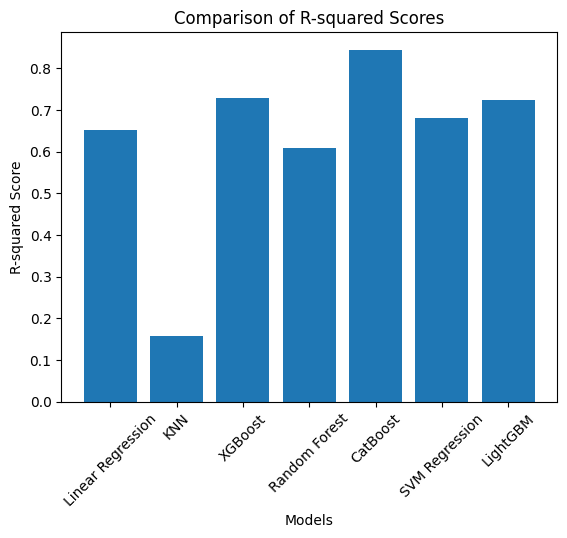

In [16]:
# Compute R-squared for each model
r2_list = []
r2_list.append(r2_score(y_test, linear_regression_predictions))
r2_list.append(r2_score(y_test, knn_predictions))
r2_list.append(r2_score(y_test, xgboost_predictions))
r2_list.append(r2_score(y_test, random_forest_predictions))
r2_list.append(r2_score(y_test, catboost_predictions))
r2_list.append(r2_score(y_test, svm_regression_predictions))
r2_list.append(r2_score(y_test, lightgbm_predictions))


# Plot the R-squared scores
models = ['Linear Regression', 'KNN', 'XGBoost', 'Random Forest', 'CatBoost', 'SVM Regression', 'LightGBM']
plt.bar(models, r2_list)
plt.xlabel('Models')
plt.ylabel('R-squared Score')
plt.xticks(rotation=45)
plt.title('Comparison of R-squared Scores')
plt.show()


## Cross-Validation Score

In [18]:
# Create a list of all the regressors

regressors = [
    LinearRegression(), KNeighborsRegressor(), 
    XGBRegressor(verbose=0), RandomForestRegressor(verbose=0), CatBoostRegressor(verbose=0), SVR(verbose=0), LGBMRegressor(verbose=0)]
cv_scores = []

# Perform 5-fold cross-validation for each regressor
for regressor in regressors:
    cv_pipeline = Pipeline([
    ('preprocessor', preprocessor),  ## prevent data leakage for each fold
    ('regressor', regressor)
])
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(cv_pipeline, X, y, cv=cv, scoring='r2')
    cv_scores.append(scores)



In [31]:
# Create a list of all the regressors

regressors = [
    XGBRegressor(verbose=0), RandomForestRegressor(verbose=0), CatBoostRegressor(verbose=0), SVR(verbose=0), LGBMRegressor(verbose=0)]
cv_scores1 = []
cv_scores2 = []

# Perform 5-fold cross-validation for each regressor
for regressor in regressors:
    cv_pipeline1 = Pipeline([
    ('preprocessor', preprocessor1),  ## prevent data leakage for each fold
    ('regressor', regressor)
])
    cv_pipeline2 = Pipeline([
    ('preprocessor', preprocessor2),  ## prevent data leakage for each fold
    ('regressor', regressor)
])
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores1 = cross_val_score(cv_pipeline1, X, y, cv=cv, scoring='r2')
    scores2 = cross_val_score(cv_pipeline2, X, y, cv=cv, scoring='r2')
    
    cv_scores1.append(scores1)
    cv_scores2.append(scores2)



In [32]:
cv_scores1

[array([0.72850961, 0.70191768, 0.72209984, 0.714226  , 0.69854574]),
 array([0.60254724, 0.58992274, 0.61483424, 0.59227777, 0.60898825]),
 array([0.84611085, 0.84233515, 0.84821873, 0.84668794, 0.85280672]),
 array([0.68142453, 0.66858684, 0.68415091, 0.65161843, 0.6710316 ]),
 array([0.72410724, 0.72013235, 0.72743656, 0.72050525, 0.72895338])]

In [33]:
cv_scores2

[array([0.70771877, 0.7041052 , 0.71305762, 0.70961681, 0.71550691]),
 array([0.60643323, 0.58949524, 0.61327757, 0.58589588, 0.60646917]),
 array([0.84291066, 0.84173913, 0.84800723, 0.84630678, 0.85408097]),
 array([0.65885119, 0.64385643, 0.66042781, 0.62424074, 0.64652472]),
 array([0.71934885, 0.71714387, 0.72689335, 0.72639562, 0.72395958])]

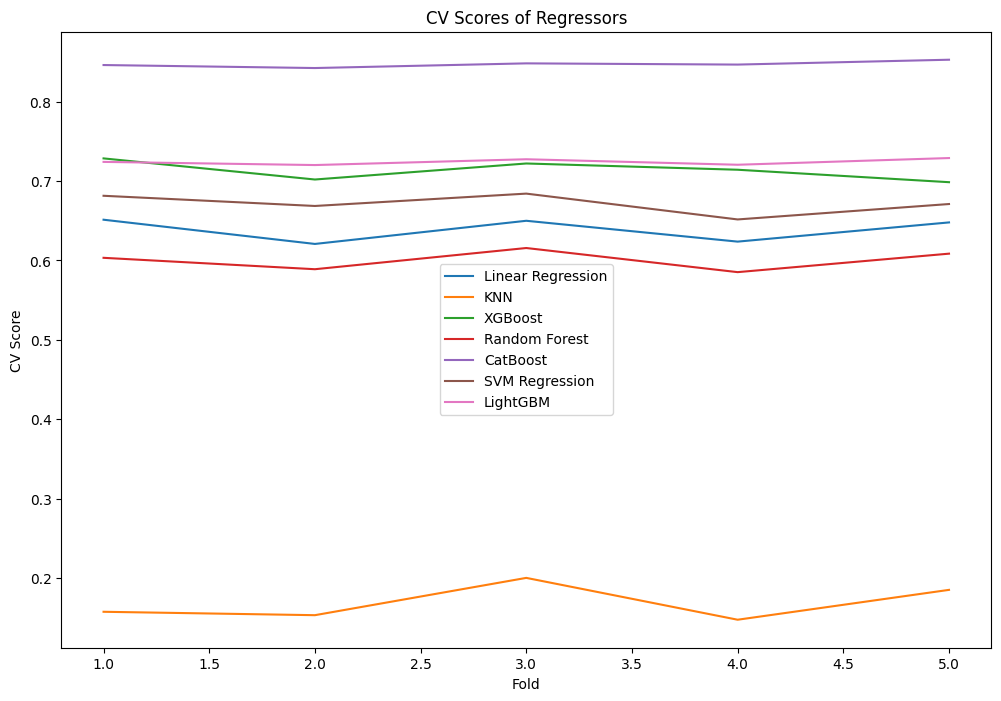

In [20]:
# Create a list of regressor names
plt.figure(figsize=(12, 8))

regressor_names = ['Linear Regression', 'KNN', 'XGBoost', 'Random Forest', 'CatBoost', 'SVM Regression', 'LightGBM']
# Plot the cv_scores for each regressor
for i in range(len(regressor_names)):
    plt.plot(range(1, 6), cv_scores[i], label=regressor_names[i])

# Add labels and title to the plot
plt.xlabel('Fold')
plt.ylabel('CV Score')
plt.title('CV Scores of Regressors')
plt.legend()

# Show the plot
plt.show()


In [21]:
np.mean(cv_scores, axis=1)

array([0.63870478, 0.16862051, 0.71305977, 0.60031617, 0.84723188,
       0.67136246, 0.72422696])

catboost, xgboost and svr performs the best, only focus on tuning catboost

## Look at Learning Curve of Catboost

In [22]:
cat_default = CatBoostRegressor(verbose=0, random_state=42, eval_metric='R2', iterations=1000, early_stopping_rounds=10)
cat_default.fit(X_train, y_train,eval_set=[(X_test, y_test)])

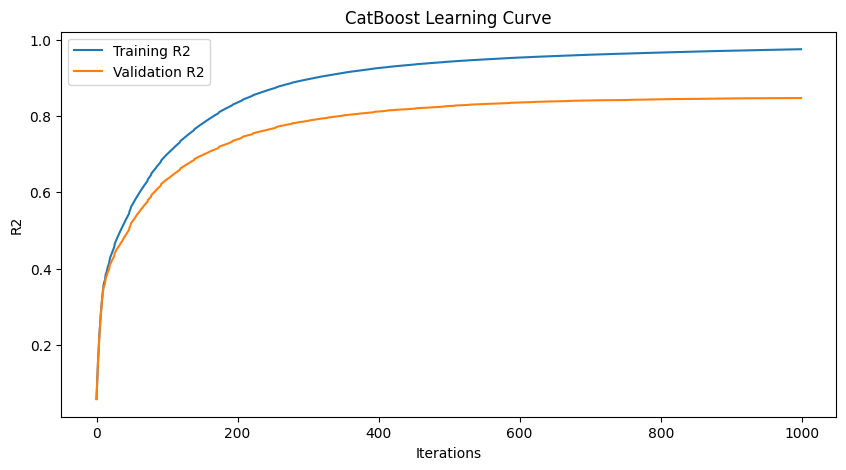

In [23]:
evals_result = cat_default.get_evals_result()

plt.figure(figsize=(10, 5))
plt.plot(evals_result['learn']['R2'], label='Training R2')
plt.plot(evals_result['validation']['R2'], label='Validation R2')
plt.title('CatBoost Learning Curve')
plt.xlabel('Iterations')
plt.ylabel('R2')
plt.legend()
plt.show()


# Hyperparam Tuning of Catboost

In [25]:
optuna.logging.set_verbosity(optuna.logging.INFO)

In [69]:
def log_trial(study, trial):
    with open("optuna_trials_0327_3.log", "a") as f:
        f.write(f"Trial {trial.number}, Params: {trial.params}, Value: {trial.value}\n")


In [70]:
def objective(trial):

    params = {
        # "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        # "depth": trial.suggest_int("depth", 3, 10),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.7, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 30, 100),
        # "l2_leaf_reg": trial.suggest_loguniform('l2_leaf_reg', 1, 10),
        # "grow_policy": trial.suggest_categorical("grow_policy", ["Depthwise", "Lossguide", "SymmetricTree"]),
    }

    regressor = CatBoostRegressor(**params, iterations = 1000, verbose=0, random_state=42)
    cv_pipeline = Pipeline([
    ('preprocessor', preprocessor),  ## prevent data leakage for each fold
    ('regressor', regressor)
])

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(cv_pipeline, X, y, cv=cv, scoring='r2')
    
    return np.mean(scores)

In [71]:
pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)
study = optuna.create_study(pruner=pruner ,direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar = True, callbacks=[log_trial])

[I 2024-03-27 22:58:32,632] A new study created in memory with name: no-name-f81c3cfc-a86f-4da0-af61-5907798fd3f7


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-03-27 22:58:51,584] Trial 0 finished with value: 0.8473367874100497 and parameters: {'colsample_bylevel': 0.8938012165138116, 'min_data_in_leaf': 57}. Best is trial 0 with value: 0.8473367874100497.
[I 2024-03-27 22:59:09,722] Trial 1 finished with value: 0.8454884521052038 and parameters: {'colsample_bylevel': 0.7004402413742544, 'min_data_in_leaf': 100}. Best is trial 0 with value: 0.8473367874100497.
[I 2024-03-27 22:59:27,890] Trial 2 finished with value: 0.8463715454242513 and parameters: {'colsample_bylevel': 0.7622887799066101, 'min_data_in_leaf': 60}. Best is trial 0 with value: 0.8473367874100497.
[I 2024-03-27 22:59:44,851] Trial 3 finished with value: 0.8460938180188492 and parameters: {'colsample_bylevel': 0.8284096662097552, 'min_data_in_leaf': 87}. Best is trial 0 with value: 0.8473367874100497.
[I 2024-03-27 23:00:03,008] Trial 4 finished with value: 0.8456228487562327 and parameters: {'colsample_bylevel': 0.7865410142999241, 'min_data_in_leaf': 38}. Best is tria

Trial 33, Params: {'learning_rate': 0.09966350211048373, 'depth': 6, 'colsample_bylevel': 0.8123896401483792, 'min_data_in_leaf': 36, 'l2_leaf_reg': 4.327467555973681, 'grow_policy': 'SymmetricTree'}, Value: 0.8311007339707256

Best trial: {'learning_rate': 0.0999031637785828, 'depth': 9, 'colsample_bylevel': 0.6510500841306683, 'min_data_in_leaf': 60, 'l2_leaf_reg': 1.439528364552419, 'grow_policy': 'Depthwise'}


Best trial: {'learning_rate': 0.09935127352589898, 'depth': 10, 'colsample_bylevel': 0.8910216469525587, 'min_data_in_leaf': 40, 'l2_leaf_reg': 1.1462170259892346, 'grow_policy': 'Depthwise'}


Best trial: {'colsample_bylevel': 0.9742367765919205}


In [72]:
print('Best trial:', study.best_trial.params)

Best trial: {'colsample_bylevel': 0.9823276993302044, 'min_data_in_leaf': 43}


In [73]:
import json

with open('best_trial_col+leaf_50.json', 'w') as f:
    json.dump(study.best_trial.params, f)

可选best params：
colsample_bylevel=0.8123896401483792，colsample_bylevel: 0.9955308757638807，  
{'colsample_bylevel': 0.9823276993302044, 'min_data_in_leaf': 43}

# Compare

### Single Test Prediction

In [31]:
regressors = [CatBoostRegressor(verbose=0, random_state=42, iterations=10000, eval_metric='R2'),
                CatBoostRegressor(verbose=0, random_state=42, iterations=10000, eval_metric='R2', colsample_bylevel=0.8123896401483792),
              CatBoostRegressor(verbose=0, random_state=42, iterations=10000, eval_metric='R2', **study.best_trial.params)]

r2_cat_list = []
for regressor in regressors:
    regressor.fit(X_train, y_train,eval_set=[(X_test, y_test)])
    y_pred = regressor.predict(X_test)
    r2_cat_list.append(r2_score(y_test, y_pred))

In [32]:
r2_cat_list

[0.8536099662103243, 0.8549335665561361, 0.8540718972587088]

### Cross-validation Score

In [74]:
regressors = [
    # CatBoostRegressor(verbose=0, random_state=42, iterations=10000, eval_metric='R2'),
                # CatBoostRegressor(verbose=0, random_state=42, iterations=10000, eval_metric='R2', colsample_bylevel=0.8123896401483792),
              CatBoostRegressor(verbose=0, random_state=42, iterations=16000, eval_metric='R2', colsample_bylevel=0.9955308757638807),
              CatBoostRegressor(verbose=0, random_state=42, iterations=16000, eval_metric='R2', **study.best_trial.params)]
cv_scores_cat = []

# Perform 5-fold cross-validation for each regressor
for regressor in regressors:
    cv_pipeline = Pipeline([
    ('preprocessor', preprocessor),  ## prevent data leakage for each fold
    ('regressor', regressor)
])
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(cv_pipeline, X, y, cv=cv, scoring='r2')
    cv_scores_cat.append(scores)

print(cv_scores_cat)



[array([0.85316919, 0.85075267, 0.8558779 , 0.85331215, 0.85993069]), array([0.85225631, 0.85022183, 0.85428538, 0.85308913, 0.85993505])]


In [75]:
print([np.mean(x) for x in cv_scores_cat])

[0.854608520079456, 0.8539575400077064]


### Plot Learning Curve

to examine if there is any overfitting

In [ ]:
cat_best = CatBoostRegressor(verbose=0, random_state=42, iterations=15000, eval_metric='R2', **study.best_trial.params)
cat_best.fit(X_train, y_train,eval_set=[(X_test, y_test)])


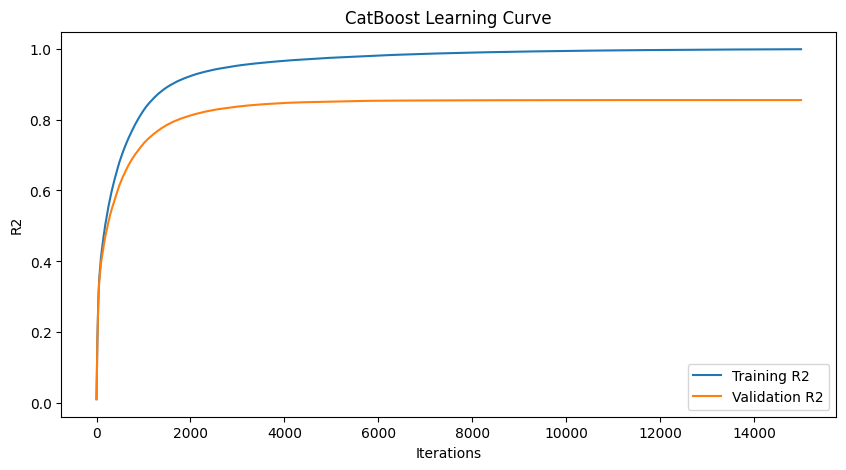

In [55]:
evals_result = cat_best.get_evals_result()

plt.figure(figsize=(10, 5))
plt.plot(evals_result['learn']['R2'], label='Training R2')
plt.plot(evals_result['validation']['R2'], label='Validation R2')
plt.title('CatBoost Learning Curve')
plt.xlabel('Iterations')
plt.ylabel('R2')
plt.legend()
plt.show()

CatBoostRegressor(verbose=0): array([0.84611085, 0.84233515, 0.84821873, 0.84668794, 0.85280672])  
CatBoostRegressor(iterations = 5000, early_stopping_rounds=10, verbose=0): array([0.85089178, 0.84897483, 0.85235442, 0.85138014, 0.85768139])  

CatBoostRegressor(iterations = 10000, early_stopping_rounds=10, verbose=0, random_state=42): [0.85192791, 0.84981073, 0.8545769 , 0.85179019, 0.85987853]  
CatBoostRegressor(**best_params_30, iterations = 10000, early_stopping_rounds=10, verbose=0, random_state=42): [0.80586611, 0.80034731, 0.81394158, 0.81441955, 0.81914308]

In [36]:
print([np.mean(x) for x in cv_scores_cat])

[0.853596852426824, 0.8538020582532397, 0.8542571191811685]


# Examine Feature Importance

In [7]:
import pickle as pkl
model = pkl.load(open('model/cat_5.pkl', 'rb'))

In [18]:
X.shape

(8000, 55)

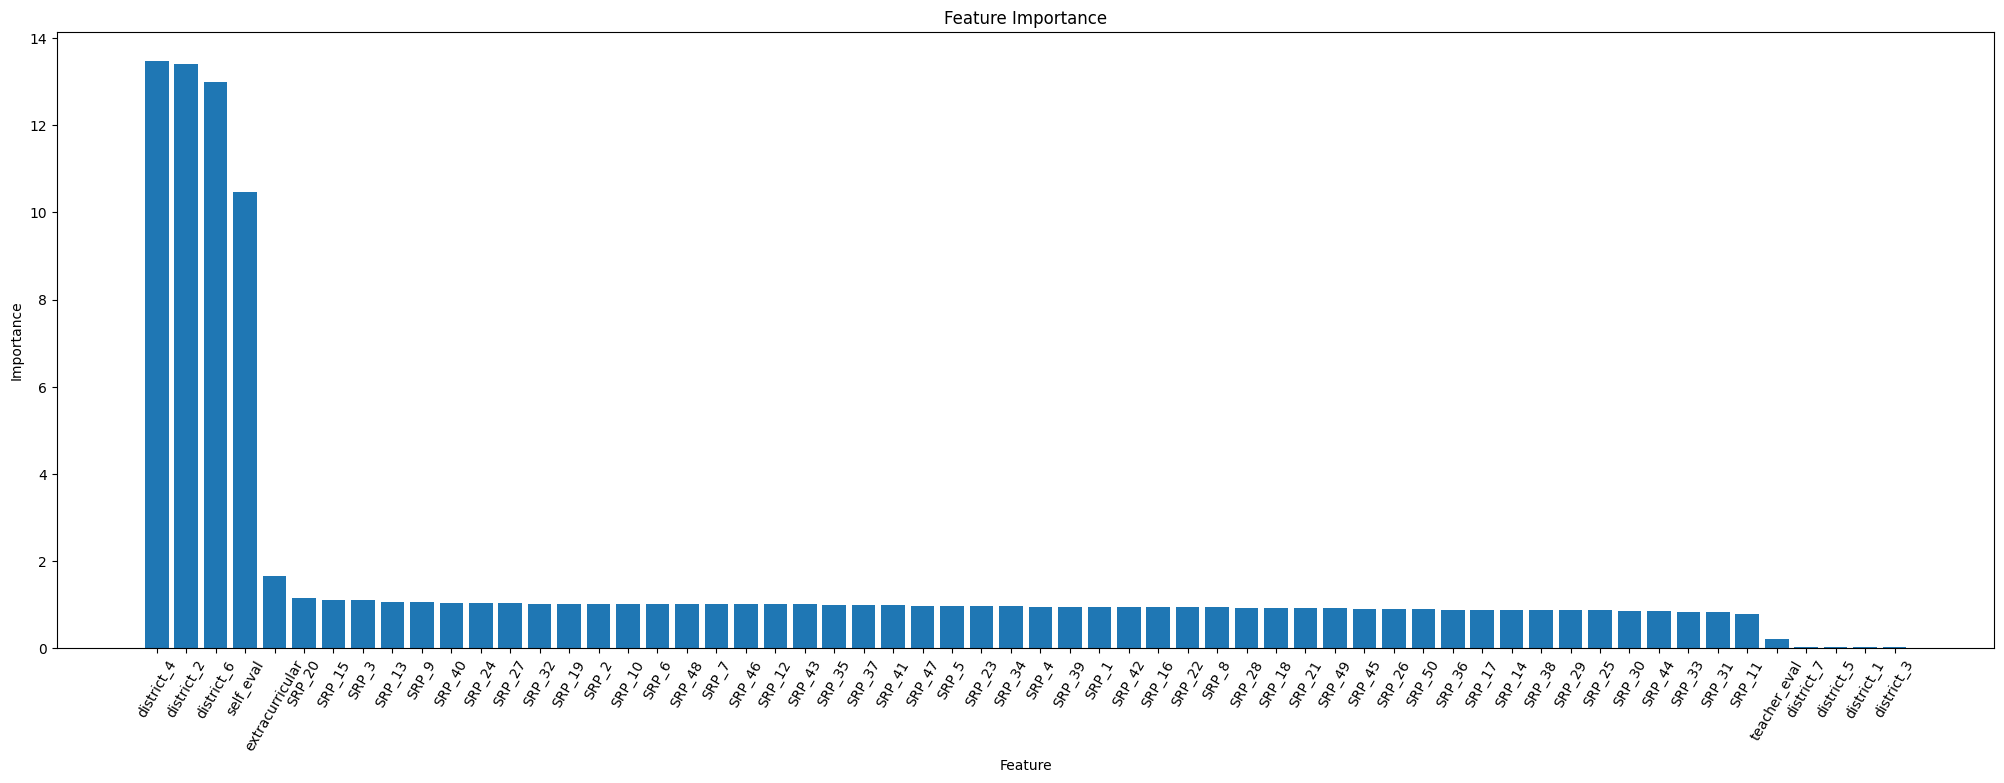

In [24]:
feature_names = ['self_eval', 'teacher_eval', 'extracurricular', 
       'SRP_1', 'SRP_2', 'SRP_3', 'SRP_4', 'SRP_5', 'SRP_6', 'SRP_7', 'SRP_8',
       'SRP_9', 'SRP_10', 'SRP_11', 'SRP_12', 'SRP_13', 'SRP_14', 'SRP_15',
       'SRP_16', 'SRP_17', 'SRP_18', 'SRP_19', 'SRP_20', 'SRP_21', 'SRP_22',
       'SRP_23', 'SRP_24', 'SRP_25', 'SRP_26', 'SRP_27', 'SRP_28', 'SRP_29',
       'SRP_30', 'SRP_31', 'SRP_32', 'SRP_33', 'SRP_34', 'SRP_35', 'SRP_36',
       'SRP_37', 'SRP_38', 'SRP_39', 'SRP_40', 'SRP_41', 'SRP_42', 'SRP_43',
       'SRP_44', 'SRP_45', 'SRP_46', 'SRP_47', 'SRP_48', 'SRP_49', 'SRP_50','district_1', 'district_2', 'district_3', 'district_4', 'district_5', 'district_6', 'district_7']


# Get feature importance
feature_importance = model.get_feature_importance()

# Create a dictionary of feature importance with corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort the feature importance dictionary by values in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Extract the sorted feature names and importance values
sorted_feature_names = [item[0] for item in sorted_feature_importance]
sorted_feature_values = [item[1] for item in sorted_feature_importance]

# Plot the sorted feature importance
plt.figure(figsize=(25, 8))
plt.bar(sorted_feature_names, sorted_feature_values)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=60)
plt.title('Feature Importance')
plt.show()


# Use on test.csv

In [58]:
df_test = pd.read_csv('test.csv')
df_test.head()

,SEQN,self_eval,teacher_eval,extracurricular,district,SRP_1,SRP_2,SRP_3,SRP_4,SRP_5,...,SRP_41,SRP_42,SRP_43,SRP_44,SRP_45,SRP_46,SRP_47,SRP_48,SRP_49,SRP_50
0,492834,1,1,5,3,-0.873,-0.337,-0.350,0.845,-0.437,...,0.025,0.154,-0.417,-1.672,2.029,1.802,-0.302,0.051,-0.350,1.438
1,309349,3,2,9,6,-0.948,1.002,-0.936,-0.100,1.134,...,0.079,0.189,1.065,-0.679,-2.169,1.265,0.828,0.078,-0.540,-1.024
2,468308,1,1,1,1,-0.356,0.283,0.708,0.740,-1.205,...,1.890,0.196,0.345,0.116,0.219,0.555,-0.829,0.019,0.906,2.146
3,838812,2,2,2,1,-0.135,-2.024,0.922,1.138,0.167,...,-0.035,0.496,-0.662,1.664,0.037,-1.263,0.043,-0.021,0.451,0.617
4,947936,4,4,8,6,-0.955,0.906,0.494,-0.020,-0.515,...,0.698,0.004,0.044,-0.977,1.434,-0.747,0.453,0.573,-1.039,-0.782


In [59]:
X_training = preproc_pipeline.fit_transform(X)
y_training = y

X_testing = preproc_pipeline.transform(df_test)

In [60]:
cat_final = CatBoostRegressor(verbose=0, random_state=42, eval_metric='R2', iterations=16000, **study.best_trial.params)
cat_final.fit(X_training, y)

In [61]:
import pickle
pickle.dump(cat_final, open('model/cat_5.pkl', 'wb'))

In [62]:
cat_final_predictions = cat_final.predict(X_testing)

In [63]:
submission = df_test[['SEQN']]
submission['y'] = cat_final_predictions

In [64]:
submission.to_csv('submission/503kaggle_submission_5.csv', index=False)